# Demo for 2d DOT

In [1]:
import chainer
from chainer import Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L

from chainer import cuda
#import numpy as xp
gpu_device = 0
cuda.get_device(gpu_device).use()

import numpy as np
import cupy as xp

from model import *
import DOT
import sklearn.datasets

from matplotlib import pyplot as plt
%matplotlib inline

def show_three_figures(y, ty1, ty2, X_train, xmin, xmax, ymin, ymax):
    plt.style.use('seaborn-darkgrid') 
    plt.figure(figsize=(20,5))


    plt.subplot(1, 4, 1)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title("Training samples", fontsize=20)
    plt.scatter(X_train[:,:1], X_train[:,1:], alpha=0.5, color='gray', marker='o')
    
    plt.subplot(1, 4, 2)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title("Samples by G", fontsize=20)
    y_d = y#.data
    plt.scatter(y_d[:,:1], y_d[:,1:], alpha=0.5, color='blue', marker='o', label='y')

    plt.subplot(1, 4, 3)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title("DOT", fontsize=20)
    y_d = ty1#.data
    plt.scatter(y_d[:,:1], y_d[:,1:], alpha=0.5, color='red', marker='o', label='ty')
    
    plt.subplot(1, 4, 4)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title("Naive", fontsize=20)
    y_d = ty2#.data
    plt.scatter(y_d[:,:1], y_d[:,1:], alpha=0.5, color='red', marker='o', label='ty')
    
    plt.show()

In [2]:
def prepare_swissroll_data(BATCH_SIZE=1000):
    data = sklearn.datasets.make_swiss_roll(
                    n_samples=BATCH_SIZE,
                    noise=0.25
                )[0]
    data = data.astype('float32')[:, [0, 2]]
    data /= 7.5 # stdev plus a little
    return data


def prepare_25gaussian_data(BATCH_SIZE=1000):
    dataset = []
    for i in range(BATCH_SIZE//25):
        for x in range(-2, 3):
            for y in range(-2, 3):
                point = np.random.randn(2)*0.05
                point[0] += 2*x
                point[1] += 2*y
                dataset.append(point)
    dataset = np.array(dataset, dtype=np.float32)
    np.random.shuffle(dataset)
    dataset /= 2.828 # stdev
    return dataset

# 25 Gaussians

In [3]:
G = Generator(n_hidden=2, noize='uni', non_linear=F.leaky_relu, final=F.identity)
serializers.load_npz("trained_models/G_25gaussians_WGAN-GP.npz", G)
D = Discriminator(non_linear=F.leaky_relu, final=F.identity)
serializers.load_npz("trained_models/D_25gaussians_WGAN-GP.npz", D)

if gpu_device==0:
    G.to_gpu()
    D.to_gpu()

X_train = prepare_25gaussian_data(BATCH_SIZE=1000)

In [4]:
lcs = []
for i in range(10):
    lcs.append(DOT.eff_K(G, D, 100).tolist())
    
K = xp.mean(xp.array(lcs))
K

array(1.97768995)

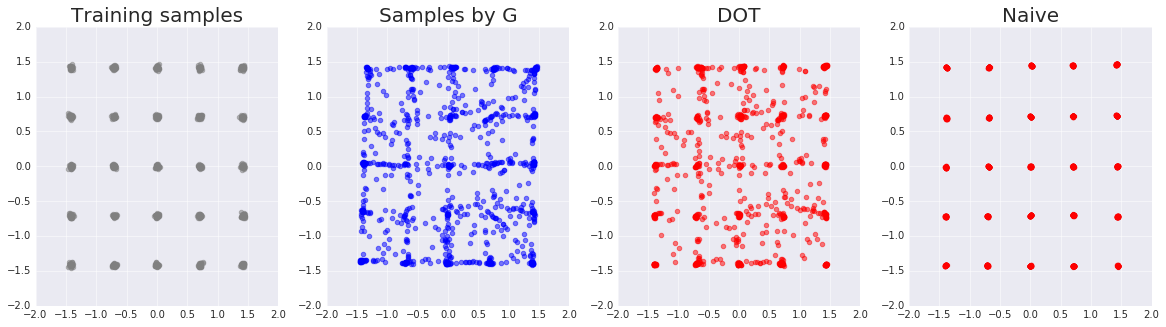

In [5]:
Zy = G.make_hidden(1000)

y_xp = G(Zy).data
Opt = chainer.optimizers.Adam(0.01, beta1=0., beta2=0.9)
T = DOT.Transporter_in_target(G, D, K, Opt, y_xp, mode='dot')

DOT.discriminator_optimal_transport_from(y_xp, T, 100)
x_va = T.get_x_va().data

Opt = chainer.optimizers.Adam(0.01, beta1=0., beta2=0.9)
T = DOT.Transporter_in_target(G, D, K, Opt, y_xp, mode='naive')

DOT.discriminator_optimal_transport_from(y_xp, T, 100)
x_va2 = T.get_x_va().data

if gpu_device==0:
    y_xp = cuda.to_cpu(y_xp)
    x_va = cuda.to_cpu(x_va)
    x_va2 = cuda.to_cpu(x_va2)
    
show_three_figures(y_xp, x_va, x_va2, X_train, -2,2,-2,2)

# Swissroll

In [6]:
G = Generator(n_hidden=2, noize='uni', non_linear=F.leaky_relu, final=F.identity)
serializers.load_npz("trained_models/G_swissroll_WGAN-GP.npz", G)
D = Discriminator(non_linear=F.leaky_relu, final=F.identity)
serializers.load_npz("trained_models/D_swissroll_WGAN-GP.npz", D)

if gpu_device==0:
    G.to_gpu()
    D.to_gpu()

X_train = prepare_swissroll_data(BATCH_SIZE=1000)

In [7]:
lcs = []
for i in range(10):
    lcs.append(DOT.eff_K(G, D, 100).tolist())
    
K = xp.mean(xp.array(lcs))
K

array(1.0532416)

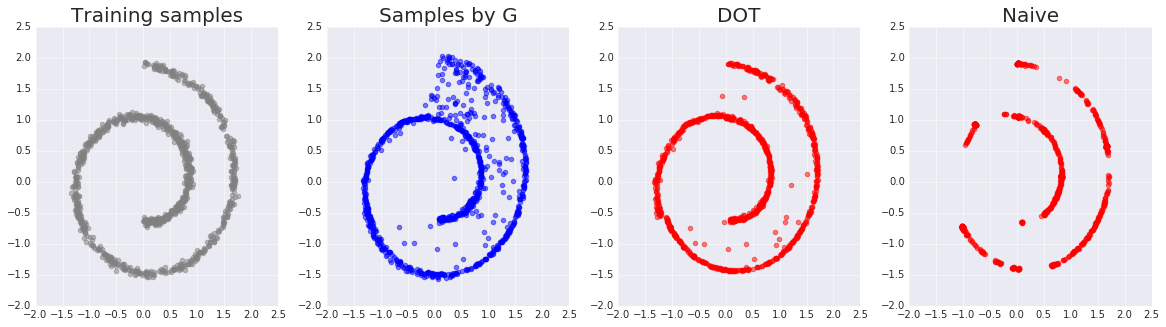

In [8]:
Zy = G.make_hidden(1000)

y_xp = G(Zy).data
Opt = chainer.optimizers.Adam(0.01, beta1=0., beta2=0.9)
T = DOT.Transporter_in_target(G, D, K, Opt, y_xp, mode='dot')

DOT.discriminator_optimal_transport_from(y_xp, T, 100)
x_va = T.get_x_va().data

Opt = chainer.optimizers.Adam(0.01, beta1=0., beta2=0.9)
T = DOT.Transporter_in_target(G, D, K, Opt, y_xp, mode='naive')

DOT.discriminator_optimal_transport_from(y_xp, T, 100)
x_va2 = T.get_x_va().data

if gpu_device==0:
    y_xp = cuda.to_cpu(y_xp)
    x_va = cuda.to_cpu(x_va)
    x_va2 = cuda.to_cpu(x_va2)
    
show_three_figures(y_xp, x_va, x_va2, X_train, -2,2.5,-2,2.5)